In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon (only needs to be done once)
import nltk
nltk.download('vader_lexicon')
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import mean_squared_error

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\anant\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\anant\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:


# Load datasets
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]
    return pd.DataFrame(data)




# Sentiment analysis


In [4]:
business_df = load_data('yelp_academic_dataset_business.json')
reviews_df = load_data('yelp_academic_dataset_review.json')

In [5]:
# Merge datasets on business_id
merged_df = reviews_df.merge(business_df, on='business_id', how='inner')


In [6]:
sia = SentimentIntensityAnalyzer()
merged_df['sentiment_score'] = merged_df['text'].apply(
    lambda x: sia.polarity_scores(x)['compound']
)


In [7]:
merged_df.head()

,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,name,...,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours,sentiment_score
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,...,19454,40.210196,-75.223639,3.0,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'...",0.8597
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,Body Cycle Spinning Studio,...,19119,39.952103,-75.172753,5.0,144,0,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Active Life, Cycling Classes, Trainers, Gyms, ...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3...",0.9858
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,Kettle Restaurant,...,85713,32.207233,-110.980864,3.5,47,1,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",None,0.9201
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,...,19114,40.079848,-75.025080,4.0,181,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21...",0.9588
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,Melt,...,70119,29.962102,-90.087958,4.0,32,0,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '...",0.9804


In [ ]:
df = merged_df([])

In [ ]:

# Aggregate review data by business
aggregated_reviews = merged_df.groupby('business_id').agg({
    'stars_x': 'mean',  # Average review star rating
    'sentiment_score': 'mean',  # Average sentiment score
    'useful': 'sum',  # Total useful votes
    'funny': 'sum',  # Total funny votes
    'cool': 'sum'    # Total cool votes
}).reset_index()

# Merge aggregated data with business data
final_df = business_df.merge(aggregated_reviews, on='business_id', how='left')

# Feature selection
features = [
    'review_count', 'stars_x', 'sentiment_score',
    'useful', 'funny', 'cool'
]
X = final_df[features].fillna(0)
y = final_df['stars']  # Target variable

# Train-test split


In [20]:
# X.head()
X_new = X.copy()


In [21]:
X_new.head()

,review_count,stars_x,sentiment_score,useful,funny,cool
0,7,4.857143,0.656614,9,3,1
1,15,3.133333,0.618500,19,6,6
2,22,3.500000,0.794850,21,20,12
3,80,4.057471,0.695723,131,47,95
4,13,4.692308,0.888331,2,0,0


In [22]:
X_new.drop(['stars_x','useful','funny','cool','review_count'], axis=1, inplace=True)
X_new.head(2)

,sentiment_score
0,0.656614
1,0.618500


In [37]:
X.drop(['stars_x', 'useful', 'funny', 'cool'], axis=1, inplace=True)

In [38]:
X.head()

,review_count,sentiment_score
0,7,0.656614
1,15,0.618500
2,22,0.794850
3,80,0.695723
4,13,0.888331


In [39]:
X.corr()

,review_count,sentiment_score
review_count,1.000000,0.111164
sentiment_score,0.111164,1.000000


In [40]:
y.head()

0    5.0
1    3.0
2    3.5
3    4.0
4    4.5
Name: stars, dtype: float64

In [29]:
import numpy as np
import matplotlib.pyplot as plt

In [41]:
import pickle

## following Regression is done using X = sentiment score and Review count

c:\Users\anant\anaconda3\envs\DL\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE for X (review_count and Sentiment score): 0.49452430390085755
Model Performance Metrics:
Root Mean Squared Error (RMSE): 0.4945
Mean Absolute Error (MAE): 0.3788
R² Score: 0.7442


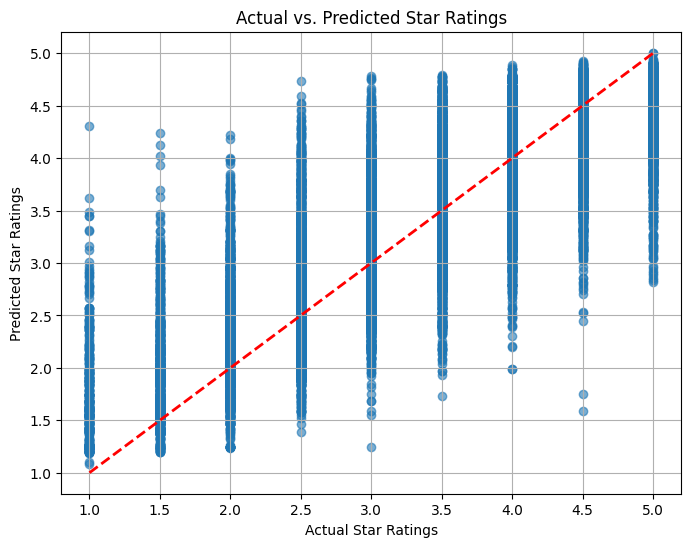

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE for X (review_count and Sentiment score): {rmse}")


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Model Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.title("Actual vs. Predicted Star Ratings")
plt.xlabel("Actual Star Ratings")
plt.ylabel("Predicted Star Ratings")
plt.grid(True)
plt.show()



# Assuming "model" is your trained machine learning model

with open('my_model.pkl', 'wb') as file:

    pickle.dump(xgb, file) 


## follwing regerssion is done with X = Sentiment_score only

In [43]:
X_new.head()

,sentiment_score
0,0.656614
1,0.618500
2,0.794850
3,0.695723
4,0.888331


----------------------------------------------------------------/n
RMSE for X_new (Sentiment score): 0.5016604849595123
Model Performance Metrics:
Root Mean Squared Error (RMSE): 0.5017
Mean Absolute Error (MAE): 0.3881
R² Score: 0.7367


c:\Users\anant\anaconda3\envs\DL\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


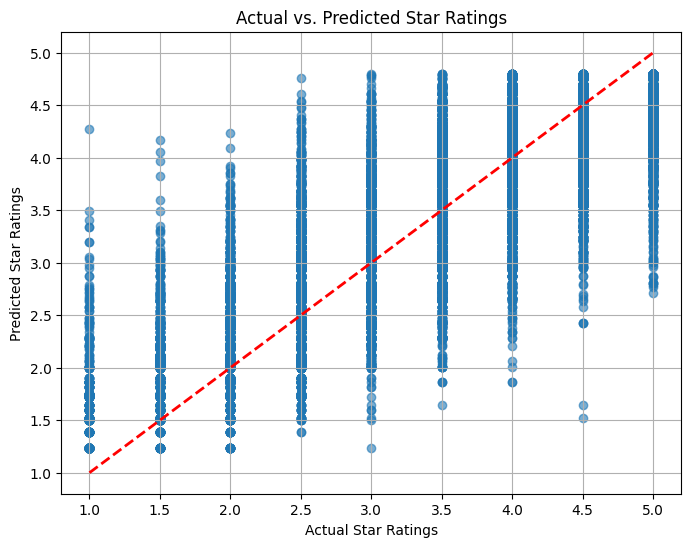

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb.fit(X_train, y_train)
print("----------------------------------------------------------------/n")
# Predict and evaluate
y_pred = xgb.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE for X_new (Sentiment score): {rmse}")


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Model Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.title("Actual vs. Predicted Star Ratings")
plt.xlabel("Actual Star Ratings")
plt.ylabel("Predicted Star Ratings")
plt.grid(True)
plt.show()

with open('senti_score.pkl', 'wb') as file:

    pickle.dump(xgb, file) 


In [45]:
final_df.to_csv('df_with_sentimentscore_and_merged.csv')